# SMS Message Ham/Spam Detection

In this project, I have explored and compared text preprocessing and feature selection methods among word count, character count, bag of words, removing stop words, stemming, and Lemmatization. Logistic regression classifier is used to detect ham or spam SMS messages. The dataset is a collection of 5,574 text messages in English, taggled according being ham (legitimate) or spam. The originate dataset can be found at https://archive.ics.uci.edu/ml/datasets/SMS+Spam+Collection.

### Import modules and load dataset. 

In [1]:
#import modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

#load data and view data
sms = pd.read_csv('spam.csv', sep=',', encoding='Latin-1')
print(sms.shape)
sms.head()

(5572, 5)


,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


### Remove empty columns and give existing columns meaningful names.

In [2]:
#drop meaningless columns
sms = sms.drop(['Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4'], axis=1)
#give meaningful names for exist columns
sms.columns = ['label', 'texts']
#view data
print(sms.shape)
sms.head()

(5572, 2)


,label,texts
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


### Exploratory data analysis.

Distribution by label: Ham count is more than five times as many as spam. 

/Users/jinghao/anaconda/lib/python3.6/site-packages/pandas/plotting/_core.py:178: UserWarning: 'colors' is being deprecated. Please use 'color'instead of 'colors'
  warnings.warn(("'colors' is being deprecated. Please use 'color'"


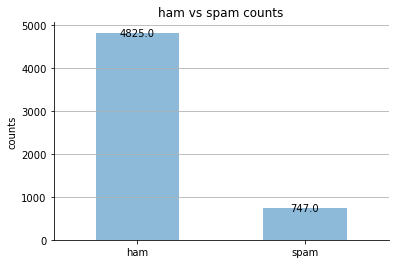

In [3]:
#visualize ham vs spam counts
fig = plt.figure()
ax = fig.add_subplot(111)
sms['label'].value_counts().plot(kind='bar', colors = '#1f77b4', alpha=0.5, grid=True)
plt.ylabel('counts')
plt.title('ham vs spam counts')
plt.xticks(rotation='horizontal')
ax.xaxis.grid(which="major")
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
for p in ax.patches:
    ax.annotate(np.round(p.get_height(),decimals=2), (p.get_x()+p.get_width()/2., p.get_height()), ha='center', va='center')

Now let's look into texts. Lowering cases and striping punctuations will make text an easier string format. To discover anything interesting, I start by counting number of words ("word_count") and number of characters ("char_count") appeared in each SMS message.

In [4]:
#lowering case characters and stripping punctuation of texts
from string import punctuation
def preprocess1 (str):
    """ str --> str
    lower case and strip punctuations of a string
    """
    for p in list(punctuation):
        str = str.lower().replace(p, '')
    return str
sms['texts'] = sms.texts.apply(preprocess1)

#creating word count feature as "word_count"
def word_count (str):
    """str --> int
    return the number of words appeared in a string
    """
    return len(str.split())
sms['word_count'] = sms.texts.apply(word_count)

#creating character count feature as "char_count"
def char_count (str):
    """ str --> int
    return the number of character count of a string
    """
    return len(list(str))
sms['char_count'] = sms.texts.apply(char_count)

#vew new data set
print(sms.shape)
sms.head()

(5572, 4)


,label,texts,word_count,char_count
0,ham,go until jurong point crazy available only in ...,20,102
1,ham,ok lar joking wif u oni,6,23
2,spam,free entry in 2 a wkly comp to win fa cup fina...,28,149
3,ham,u dun say so early hor u c already then say,11,43
4,ham,nah i dont think he goes to usf he lives aroun...,13,59


Let's visualize distribution pattern of word count by plotting a normalized histgram. Something interesting discovered when we split ham and spam. Spam messages are in general consists of more words! That also makes sense from real life experience. 

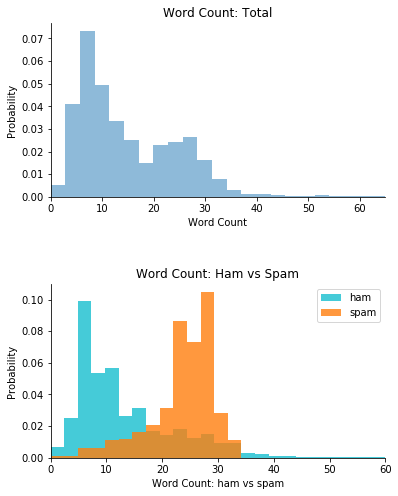

In [5]:
#visualize word_count
fig = plt.figure(figsize=(6,8))
ax1 = fig.add_subplot(2, 1, 1)
ax1.hist(sms['word_count'], normed=True, bins=60, color='#1f77b4', alpha=0.5)
plt.xlim(0,65)
plt.xlabel('Word Count')
plt.ylabel('Probability')
plt.title('Word Count: Total')
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)

ax2 = fig.add_subplot(2, 1, 2)
bins = np.histogram(np.hstack((sms.loc[sms.label=='ham']['word_count'], sms.loc[sms.label=='spam']['word_count'])), bins=70)[1]
plt.hist(sms.loc[sms.label=='ham']['word_count'], bins, normed=True, color='#17becf', alpha=0.8, label='ham')
plt.hist(sms.loc[sms.label=='spam']['word_count'], bins, normed=True, color='#ff7f0e', alpha=0.8, label='spam')
plt.legend(loc='upper right')
plt.xlim(0, 60)
plt.xlabel('Word Count: ham vs spam')
plt.ylabel('Probability')
plt.title('Word Count: Ham vs Spam')

ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
plt.subplots_adjust(hspace=0.5)

Similar patterns found in character count. More than one third of spam messages fall between 140-160, and it's probably due to the fact that SMS message will be broken down into chuncks if it's more than 160 characters. 

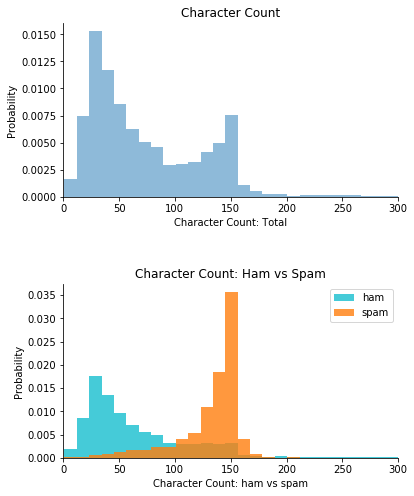

In [6]:
#visualize char_count
fig = plt.figure(figsize=(6,8))
ax1 = fig.add_subplot(2, 1, 1)
ax1.hist(sms['char_count'], bins=80,normed=True, color='#1f77b4', alpha=0.5)
plt.xlim(0,300)
plt.xlabel('Character Count: Total')
plt.ylabel('Probability')
plt.title('Character Count')
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)

ax2 = fig.add_subplot(2, 1, 2)
bins = np.histogram(np.hstack((sms.loc[sms.label=='ham']['char_count'], sms.loc[sms.label=='spam']['char_count'])), bins=80)[1]
plt.hist(sms.loc[sms.label=='ham']['char_count'], bins, normed=True, color='#17becf', alpha=0.8, label='ham')
plt.hist(sms.loc[sms.label=='spam']['char_count'], bins, normed=True, color='#ff7f0e', alpha=0.8, label='spam')
plt.legend(loc='upper right')
plt.xlim(0, 300)
plt.xlabel('Character Count: ham vs spam')
plt.ylabel('Probability')
plt.title('Character Count: Ham vs Spam')

ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
plt.subplots_adjust(hspace=0.5)

### Word Count and Character Count

Based on the above visual findings, I will use "word_count" and "char_count" as explaining variables. The logistic regression gives the test score of 0.90. Not bad. But let's try to improve using other methods.

In [7]:
#dummy code "label"
sms = pd.get_dummies(sms, columns=['label'])

#identify explaining variables and target variable
X_c = sms[['word_count', 'char_count']]
y_c = sms['label_ham']

#split data into training and test data sets
from sklearn.model_selection import train_test_split
X_c_train, X_c_test, y_c_train, y_c_test = train_test_split(X_c, y_c, test_size=0.2)

#apply LogisticRegression classfier
from sklearn.linear_model import LogisticRegression
lg = LogisticRegression().fit(X_c_train, y_c_train)
print('training set score obtained Logistic Regression: {:.2f}'.format(lg.score(X_c_train, y_c_train)))
print('test set score obtained Logistic Regression: {:.2f}'.format(lg.score(X_c_test, y_c_test)))

training set score obtained Logistic Regression: 0.90
test set score obtained Logistic Regression: 0.90


### Bag of Words

A simple way to respensent texts is bag-or-words. The basic idea is to count how often each word appears in each text in the corpus. Please see below for detailed process. With this model, the model got improved to an accuracy score of 0.98.

number of features:8373


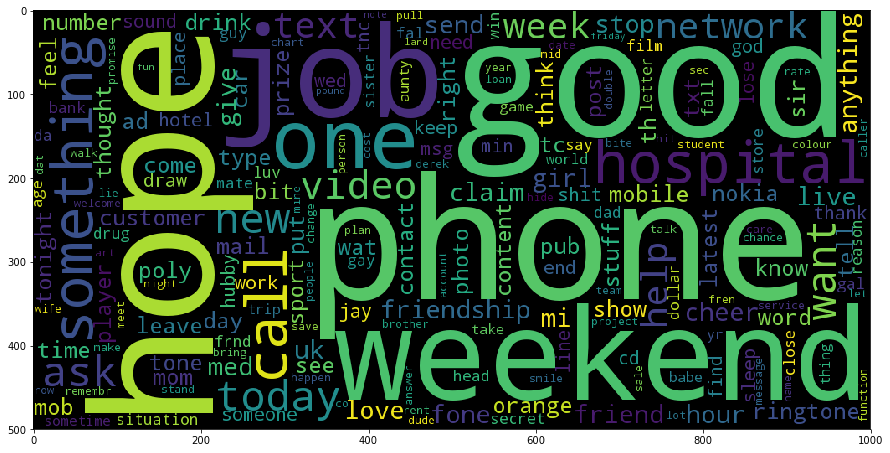

Best cross validation score: 0.98
Best parameters: {'C': 10}
Test score:0.98


In [8]:
#identify explaining variables and target variable
X_b = sms['texts']
y_b = sms['label_ham']

#split data into training and test data sets
X_b_train, X_b_test, y_b_train, y_b_test = train_test_split(X_b, y_b, test_size=0.2)

#tokenization and vocabulary building over all documents
from sklearn.feature_extraction.text import CountVectorizer
vect = CountVectorizer().fit(X_b_train)

print ('number of features:{}'.format(len(vect.vocabulary_)))

#visualize with wordcloud
from wordcloud import WordCloud
wordcloud = WordCloud(width = 1000, height = 500).generate(' '.join(vect.vocabulary_))
plt.figure(figsize=(15,8))
plt.imshow(wordcloud)
plt.show()

#tokenization and vocabulary building over all training data set
from sklearn.feature_extraction.text import CountVectorizer
vect = CountVectorizer().fit(X_b_train)

#sparse matrix encoding, resulting in one vector of word counts for each document.
X_b_train = vect.transform(X_b_train)

#import LogisticRegression classifier
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression

#grid search for best parameter
from sklearn.model_selection import GridSearchCV
param_grid = {'C': [0.001, 0.01, 0.1, 1, 10]}
grid = GridSearchCV(LogisticRegression(), param_grid, cv=5)
grid.fit(X_b_train, y_b_train)
print ('Best cross validation score: {:.2f}'.format(grid.best_score_))
print ('Best parameters:', grid.best_params_)

#fit classifier in test dataset
X_b_test = vect.transform(X_b_test)
print('Test score:{:.2f}'.format(grid.score(X_b_test, y_b_test)))

We can further improve the model by setting the value of min_df in CountVectorizer. This means we only select tokens that appear in at list min_df of documents. In this dase, I set min_df=5. The accuracy score is still 0.98, however the number of features deducted from 8373 to 1507, which improves the computation efficiency. 

number of features:1507


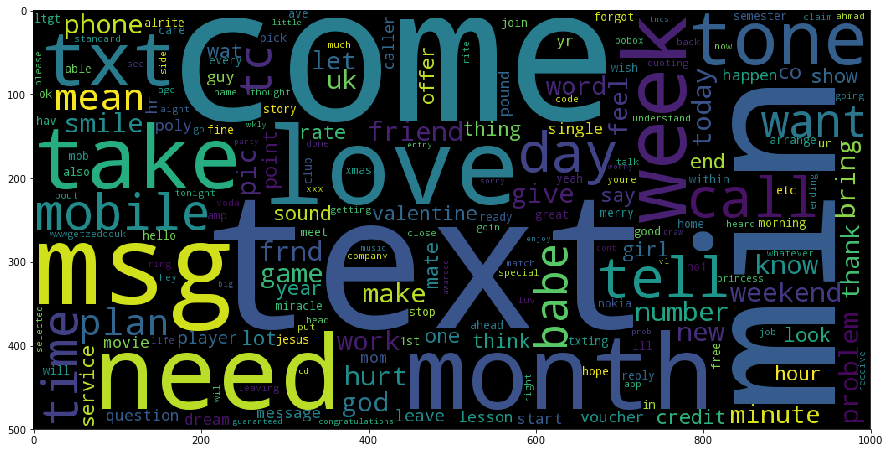

Best cross validation score: 0.98
Parameters: {'C': 10}
Test score:0.99


In [9]:
#improve the model by selecting tokens that appear in at least 5 documents
X_b = sms['texts']
y_b = sms['label_ham']
X_b_train, X_b_test, y_b_train, y_b_test = train_test_split(X_b, y_b, test_size=0.2)
vect = CountVectorizer(min_df=5).fit(X_b_train)
X_b_train = vect.transform(X_b_train)

print ('number of features:{}'.format(len(vect.vocabulary_)))

#visualize features
wordcloud = WordCloud(width = 1000, height = 500).generate(' '.join(vect.vocabulary_))
plt.figure(figsize=(15,8))
plt.imshow(wordcloud)
plt.show()

#fit in logistic regression
grid = GridSearchCV(LogisticRegression(), param_grid, cv=5)
grid.fit(X_b_train, y_b_train)
print ('Best cross validation score: {:.2f}'.format(grid.best_score_))
print ('Parameters:', grid.best_params_)
X_b_test = vect.transform(X_b_test)
print('Test score:{:.2f}'.format(grid.score(X_b_test, y_b_test)))

### Stopwords

Another way to get rid of uninformative words is by discarding stopwords. Here I will use a list of stopwords from Python. By removing the stopwords, the number of feature is further recuced to 1324. The accuracy score remains as 0.98.

number of features:1324


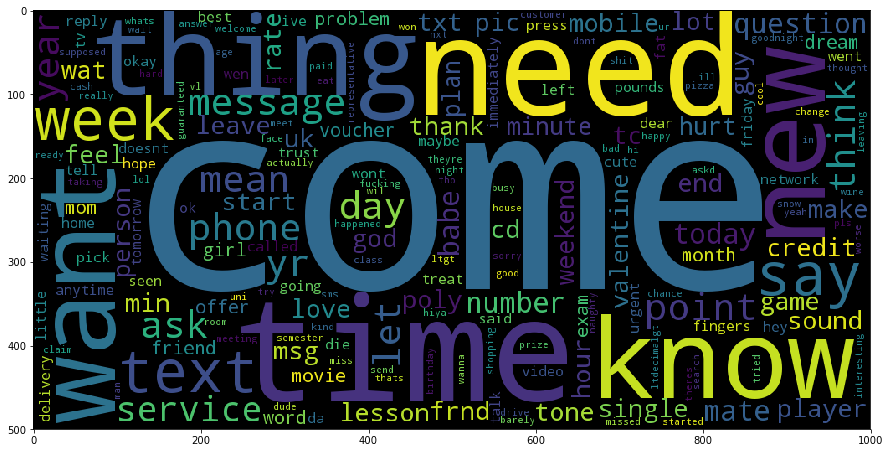

Best cross validation score: 0.98
Parameters: {'C': 10}
Test score:0.98


In [10]:
X_b = sms['texts']
y_b = sms['label_ham']
X_b_train, X_b_test, y_b_train, y_b_test = train_test_split(X_b, y_b, test_size=0.2)

#improve the model by selecting tokens that appear in at least 5 documents and discarding words that are too frequent to be informative
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
vect = CountVectorizer(min_df=5, stop_words=ENGLISH_STOP_WORDS).fit(X_b_train)
X_b_train = vect.transform(X_b_train)

print ('number of features:{}'.format(len(vect.vocabulary_)))

#visualize features
wordcloud = WordCloud(width = 1000, height = 500).generate(' '.join(vect.vocabulary_))
plt.figure(figsize=(15,8))
plt.imshow(wordcloud)
plt.show()

#grid search with LogisticRegression classifier 
grid = GridSearchCV(LogisticRegression(), param_grid, cv=5)
grid.fit(X_b_train, y_b_train)
print ('Best cross validation score: {:.2f}'.format(grid.best_score_))
print ('Parameters:', grid.best_params_)
X_b_test = vect.transform(X_b_test)
print('Test score:{:.2f}'.format(grid.score(X_b_test, y_b_test)))

### Stemming

Now let's try stemming, meaning to identify the words that have the same stem. We can potentially identify different format of verbs like "dropped", "dropping", and "drops" as one word drop, this can help avoid overfitting problems caused by identifying them as seperate features. This approach reduced number of features to 806. The accuracy score still remains the same though.

In [11]:
import nltk
from nltk.tokenize import sent_tokenize, word_tokenize
nltk.download('wordnet')
from nltk.stem.wordnet import WordNetLemmatizer
lmtzr = WordNetLemmatizer()

def stemtexts (sentence):
    s = []
    for i in sentence.split():
        s.append(lmtzr.lemmatize(i))
    return ' '.join(s)

sms['texts_stemmed'] = sms.texts.apply(stemtexts)
sms.head()


[nltk_data] Downloading package wordnet to /Users/jinghao/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


,texts,word_count,char_count,label_ham,label_spam,texts_stemmed
0,go until jurong point crazy available only in ...,20,102,1,0,go until jurong point crazy available only in ...
1,ok lar joking wif u oni,6,23,1,0,ok lar joking wif u oni
2,free entry in 2 a wkly comp to win fa cup fina...,28,149,0,1,free entry in 2 a wkly comp to win fa cup fina...
3,u dun say so early hor u c already then say,11,43,1,0,u dun say so early hor u c already then say
4,nah i dont think he goes to usf he lives aroun...,13,59,1,0,nah i dont think he go to usf he life around h...


number of features:806


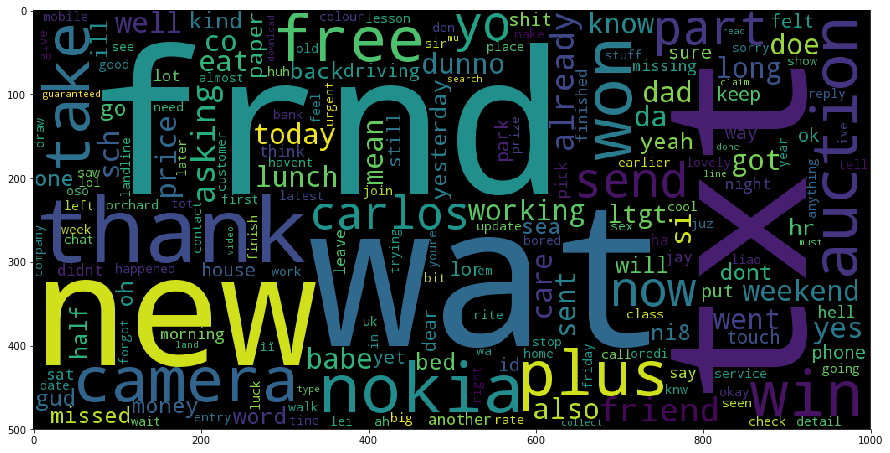

Best cross validation score: 0.98
Parameters: {'C': 10}
Test score:0.98


In [12]:
X_s = sms['texts_stemmed']
y_s = sms['label_ham']
X_s_train, X_s_test, y_s_train, y_s_test = train_test_split(X_s, y_s, test_size=0.2)
vect = CountVectorizer(min_df=10).fit(X_s_train)
X_s_train = vect.transform(X_s_train)

print ('number of features:{}'.format(len(vect.vocabulary_)))

#visualize features
wordcloud = WordCloud(width = 1000, height = 500).generate(' '.join(vect.vocabulary_))
plt.figure(figsize=(15,8))
plt.imshow(wordcloud)
plt.show()

#grid search with LogisticRegression classifier 
grid = GridSearchCV(LogisticRegression(), param_grid, cv=5)
grid.fit(X_s_train, y_s_train)
print ('Best cross validation score: {:.2f}'.format(grid.best_score_))
print ('Parameters:', grid.best_params_)
X_s_test = vect.transform(X_s_test)
print('Test score:{:.2f}'.format(grid.score(X_s_test, y_s_test)))

### Lemmatization

A similar approach is lemmatization, which takes account of morphological analysis of the word. The standard form of the word is called lemma. For example, lemma of "worse" is "bad". With lemmatization of texts, we further reduce number of features to only 736. The accuracy score still remains the same.

In [13]:
import spacy
# load spacy's English-language modules
en_nlp = spacy.load('en')
# define fuction to convert a string to a lemma string.
def spacytexts (txt):
    txt_spacy = en_nlp(txt)
    return ' '.join([token.lemma_ for token in txt_spacy])

sms['texts_lemma'] = sms.texts.apply(spacytexts)
sms.head()

,texts,word_count,char_count,label_ham,label_spam,texts_stemmed,texts_lemma
0,go until jurong point crazy available only in ...,20,102,1,0,go until jurong point crazy available only in ...,go until jurong point crazy available only in ...
1,ok lar joking wif u oni,6,23,1,0,ok lar joking wif u oni,ok lar joke wif u oni
2,free entry in 2 a wkly comp to win fa cup fina...,28,149,0,1,free entry in 2 a wkly comp to win fa cup fina...,free entry in 2 a wkly comp to win fa cup fina...
3,u dun say so early hor u c already then say,11,43,1,0,u dun say so early hor u c already then say,u dun say so early hor u c already then say
4,nah i dont think he goes to usf he lives aroun...,13,59,1,0,nah i dont think he go to usf he life around h...,nah i do not think -PRON- go to usf -PRON- liv...


number of features:736


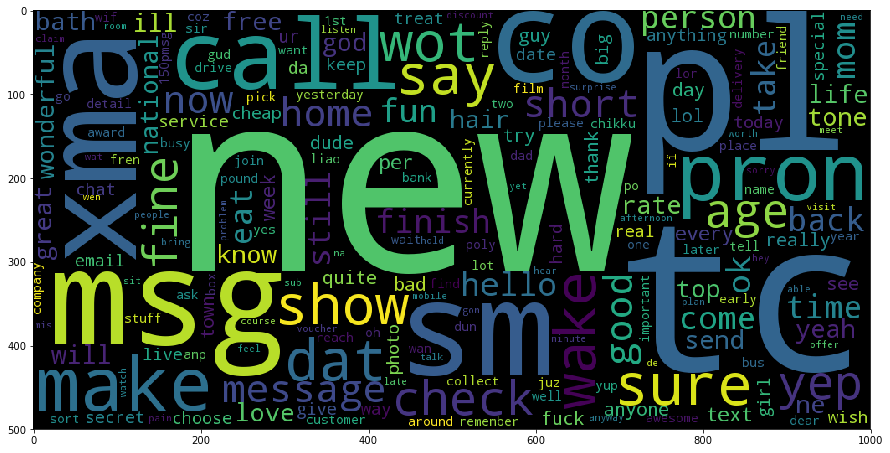

Best cross validation score: 0.98
Parameters: {'C': 10}
Test score:0.98


In [14]:
X_l = sms['texts_lemma']
y_l = sms['label_ham']
X_l_train, X_l_test, y_l_train, y_l_test = train_test_split(X_l, y_l, test_size=0.2)
vect = CountVectorizer(min_df=10).fit(X_l_train)
X_l_train = vect.transform(X_l_train)

print ('number of features:{}'.format(len(vect.vocabulary_)))

#visualize features
wordcloud = WordCloud(width = 1000, height = 500).generate(' '.join(vect.vocabulary_))
plt.figure(figsize=(15,8))
plt.imshow(wordcloud)
plt.show()

#grid search with LogisticRegression classifier 
grid = GridSearchCV(LogisticRegression(), param_grid, cv=5)
grid.fit(X_l_train, y_l_train)
print ('Best cross validation score: {:.2f}'.format(grid.best_score_))
print ('Parameters:', grid.best_params_)
X_l_test = vect.transform(X_l_test)
print('Test score:{:.2f}'.format(grid.score(X_l_test, y_l_test)))

### Further Discussion

This project is limited to logistic regression as logistic regression has advantage dealing with high-dimensional data, like text data. Further analysis can be exploring other machine learning techniques. 

SMS messages involve a lot of misspelling situation and abbriviation uses. Text normalization methods focus those topics may potentially improve the predicting power. 